# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [233]:
import pandas as pd
import numpy as np
import os
import math
import json
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from collections import defaultdict
import bisect
import scipy
from scipy.stats import gaussian_kde
from helper_functions import (create_person_offer, get_before_after_mean, train_model, printRocCurves,
                              plot_cmatrix,print_feature_importance,print_classification_report,prepare_data)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from  xgboost import XGBClassifier

%matplotlib inline
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True,)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
display(transcript.head())
# Add datetime to the dataframes:
transcript['datetime'] = pd.to_datetime(transcript['time']*3600000000000) # we don't know the exct time, so we use jan 1 1970 as strt
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [235]:
# 

# Analyse data and cleanup

In this first step we will just look into the data to get more familiar, find if there's any null values etc etc.
The data itself is pretty much selfexplaining, some comments will be done in the start of each section that will explain the data below, but not much comments in the cells with data will be made to keep it cleaner.
We will also make an effort to clean up the data here, create dummies etc etc
### Portfolio

we don't use head here as this only contain 10 items anyway, i.e this is the full table.

a few things we may need to do with this data is to turn channels and offer_type into ine-hot-encoded columns to help processing these later on

The index will be kept with it's 0-9 instead of setting index to id, the reason is that it's more readable ( at it's likily that we will do plots and graphs based on each of these( as ther's only 10) and instead add link in other tables to have this index instead of the id.

from the class room:

> Offers sent during 30-day test period (10 offers x 6 fields)
* reward: (numeric) money awarded for the amount spent
* channels: (list) web, email, mobile, social
* difficulty: (numeric) money required to be spent to receive reward
* duration: (numeric) time for offer to be open, in days
* offer_type: (string) bogo, discount, informational
* id: (string/hash)

In [236]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [237]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [238]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [239]:
for name, group in portfolio.groupby('offer_type'):
    print('###################################')
    print('#####   ',name)
    display(group.describe())

###################################
#####    bogo


,reward,difficulty,duration
count,4.000000,4.000000,4.000000
mean,7.500000,7.500000,6.000000
std,2.886751,2.886751,1.154701
min,5.000000,5.000000,5.000000
25%,5.000000,5.000000,5.000000
50%,7.500000,7.500000,6.000000
75%,10.000000,10.000000,7.000000
max,10.000000,10.000000,7.000000


###################################
#####    discount


,reward,difficulty,duration
count,4.000000,4.000000,4.000000
mean,3.000000,11.750000,8.500000
std,1.414214,5.678908,1.732051
min,2.000000,7.000000,7.000000
25%,2.000000,9.250000,7.000000
50%,2.500000,10.000000,8.500000
75%,3.500000,12.500000,10.000000
max,5.000000,20.000000,10.000000


###################################
#####    informational


,reward,difficulty,duration
count,2.0,2.0,2.000000
mean,0.0,0.0,3.500000
std,0.0,0.0,0.707107
min,0.0,0.0,3.000000
25%,0.0,0.0,3.250000
50%,0.0,0.0,3.500000
75%,0.0,0.0,3.750000
max,0.0,0.0,4.000000


In [240]:
pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis=1).drop(columns=['channels'])
#https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
display(portfolio)
display(portfolio.corr())

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


,reward,difficulty,duration,email,mobile,social,web
reward,1.000000,0.465686,0.160262,NaN,-0.078431,0.288175,-0.117647
difficulty,0.465686,1.000000,0.808414,NaN,-0.741058,-0.154957,0.244007
duration,0.160262,0.808414,1.000000,NaN,-0.529756,-0.185376,0.340557
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile,-0.078431,-0.741058,-0.529756,NaN,1.000000,0.408248,-0.166667
social,0.288175,-0.154957,-0.185376,NaN,0.408248,1.000000,-0.408248
web,-0.117647,0.244007,0.340557,NaN,-0.166667,-0.408248,1.000000


In [241]:
# this is my own logical order, nothing says it have to be this way, just what "feels better". bogo, discount, information
portfolio_my_order= [0,1,3,8,5,4,6,9,2,7]

### Profile

>Rewards program users (17000 users x 5 fields)
* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* became_member_on: (date) format YYYYMMDD
* income: (numeric)

In [242]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [243]:
# Let's change the index to ID instead for faster and easier access
profile.set_index('id', inplace=True)

In [244]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 68be06ca386d4c31939f3a4f0e3dd783 to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   became_member_on  17000 non-null  datetime64[ns]
 3   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 664.1+ KB


In [245]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


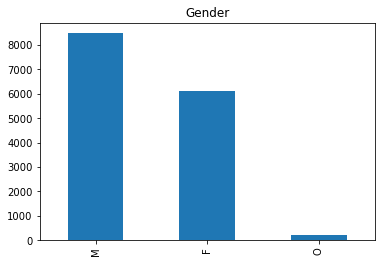

In [246]:
profile['gender'].value_counts().plot.bar(title='Gender')

In [247]:
profile['age'][profile['age'] != 118].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

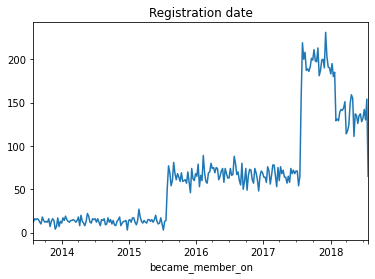

In [248]:
profile.groupby([pd.Grouper(key='became_member_on', freq='W')])['became_member_on'].count().plot(title='Registration date')

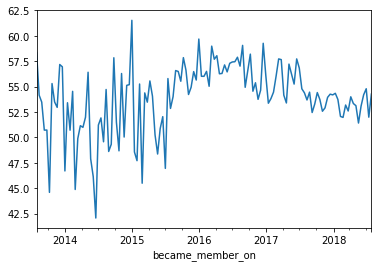

In [249]:
profile[profile['age'] != 118].groupby([pd.Grouper(key='became_member_on', freq='2W')])['age'].mean().plot()

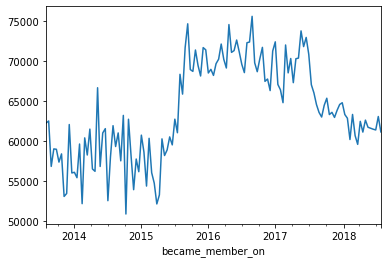

In [250]:
profile.groupby([pd.Grouper(key='became_member_on', freq='2W')])['income'].mean().plot()

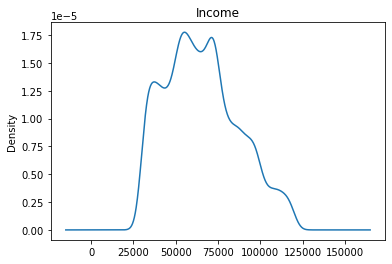

In [251]:
profile['income'].plot(kind='kde',title='Income')

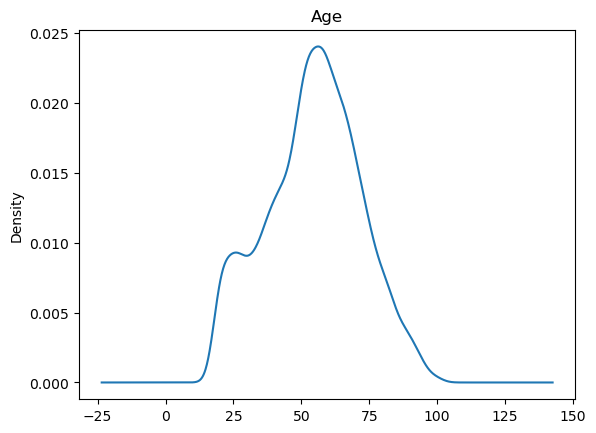

In [424]:
profile[profile['age'] != 118]['age'].plot(kind='kde',title='Age')

### Transcript

In [21]:
transcript.head()

,person,event,value,time,datetime
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1970-01-01
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1970-01-01
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1970-01-01
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1970-01-01
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1970-01-01


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   person    306534 non-null  object        
 1   event     306534 non-null  object        
 2   value     306534 non-null  object        
 3   time      306534 non-null  int64         
 4   datetime  306534 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.7+ MB


In [23]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [24]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,datetime
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1970-01-01 00:00:00
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,1970-01-01 06:00:00
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,1970-01-06 12:00:00
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,1970-01-06 12:00:00
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,1970-01-07 00:00:00
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,1970-01-08 00:00:00
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,1970-01-10 00:00:00
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,1970-01-10 06:00:00
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,1970-01-11 00:00:00
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,1970-01-16 18:00:00


In [252]:
# extract data in value, first, what column do we need?
# we have 2 offer_id ( with and without the space, so we can put these into one
new_cols={
    'offer_id':[],
    'reward': [],
    'amount': []
}
for row in transcript.itertuples():
    offer_id = None
    reward = None
    amount = None
    if 'offer_id' in row.value.keys():
        offer_id = row.value['offer_id']
    if 'offer id' in row.value.keys():
        offer_id = row.value['offer id']
    if 'reward' in row.value.keys():
        reward = row.value['reward']
    if 'amount' in row.value.keys():  
        amount = row.value['amount']
    
    new_cols['offer_id'].append(offer_id)
    new_cols['reward'].append(reward)
    new_cols['amount'].append(amount)

# Add new columns and drop value
transcript = pd.concat([transcript, pd.DataFrame(new_cols).set_index(transcript.index)], axis=1).drop(columns=['value'])

#add dummie columns for the event columns. but don't drop event.
dummies = pd.get_dummies(transcript['event'],columns=['event'])
transcript = pd.concat([transcript, dummies.set_index(transcript.index)], axis=1)


In [26]:
transcript.head(5)

,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1970-01-01,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1970-01-01,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,1970-01-01,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1970-01-01,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1970-01-01,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


In [27]:
#Let's take another look at Nan values ( important for later) 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   person           306534 non-null  object        
 1   event            306534 non-null  object        
 2   time             306534 non-null  int64         
 3   datetime         306534 non-null  datetime64[ns]
 4   offer_id         167581 non-null  object        
 5   reward           33579 non-null   float64       
 6   amount           138953 non-null  float64       
 7   offer completed  306534 non-null  uint8         
 8   offer received   306534 non-null  uint8         
 9   offer viewed     306534 non-null  uint8         
 10  transaction      306534 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3), uint8(4)
memory usage: 17.5+ MB


In [28]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [253]:
# Make the offer id more human readable, good for plots etc later
def get_offer_index(x):
    return int(portfolio.index[portfolio['id'] == x].tolist()[0]) if x else x

transcript['offer_index'] = transcript['offer_id'].apply(lambda x: get_offer_index(x))

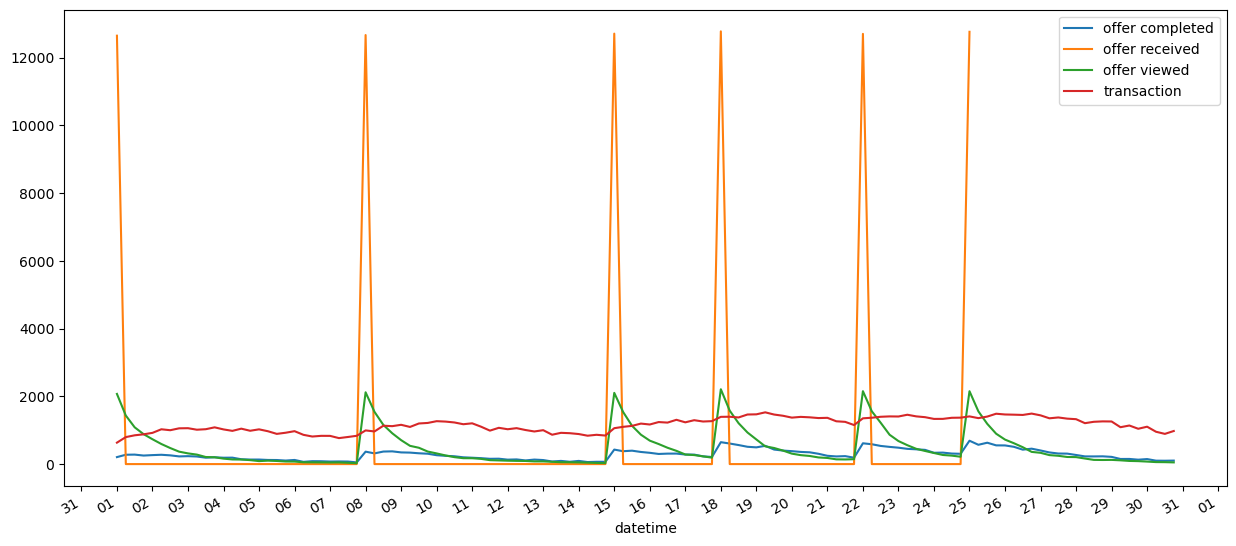

In [420]:
# Plot the number of events per type over time
freq = '6H' # 4 times per day
fig, ax = plt.subplots(figsize=(15,7))
for i, x in transcript.groupby('event'):
    x.groupby([pd.Grouper(key='datetime', freq=freq)])['event'].count().plot(x_compat=True ,ax=ax, label=i)

#set ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.legend()

In [257]:
# In the plot above we can see that we have 6 bursts of sent offer, to process this later,
# we will put these into different groups
sendouts=np.array([5,12,16,20,23])*24 # this is not the date of the sendout, rather inbetween them..
def assign_offer_burst(x):
    if x.event == "offer received":
        x.offer_burst = bisect.bisect_left(sendouts,x.time)
    return x
tqdm.pandas()
transcript["offer_burst"]=np.nan
transcript = transcript.progress_apply(assign_offer_burst,  axis=1)
display(transcript)

,person,event,time,datetime,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction,offer_index,offer_burst
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1970-01-01 00:00:00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,3.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1970-01-01 00:00:00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0,4.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,1970-01-01 00:00:00,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0,9.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1970-01-01 00:00:00,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0,6.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1970-01-01 00:00:00,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1970-01-30 18:00:00,None,NaN,1.59,0,0,0,1,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,1970-01-30 18:00:00,None,NaN,9.53,0,0,0,1,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,1970-01-30 18:00:00,None,NaN,3.61,0,0,0,1,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,1970-01-30 18:00:00,None,NaN,3.53,0,0,0,1,NaN,NaN


In [ ]:
# This was used to take a look at offers for each person, to unerstand the data better.
# for example we could see that one user can get the same offre multiple times, before completing the first
# and later use both.
n_person = 1
for i,(name, person) in enumerate(tqdm(transcript.dropna(subset=['offer_id']).groupby('person'))):    
    if i >= n_person:
        break
    for offerid, group in person.groupby(['offer_index']):
        display(group)
        #display(portfolio.loc[offerid])
    print("########")


In [ ]:
# count offer recieved per person (to see how the distributionwas done),
# any user with no offer?
# First look gave us that each user can actully get the same offer more than once??? and that combine with order made it unique to each user. 
count_offer = defaultdict(int)
pepl = set()
for name, person in tqdm(transcript[transcript['offer received']==1].groupby('person')):
    pepl.add(name)
    item = len(list(person['offer_index'].to_list()))
    count_offer[str(item)]+=1
print(json.dumps(count_offer, indent=4, sort_keys=True))

In [ ]:
x,y= zip(*sorted(count_offer.items()))
fig = plt.figure(figsize=(10,10))
plt.bar(x,y)
plt.suptitle('distribution of number of offers per person')
plt.xlabel('Number of offers')
plt.ylabel('Number of customers')

In [ ]:
# is it possible that there's a 'control group' that had 0 offers?
# yes, but it's very limited. We could try to use this later,
# but may not be enough with 6 customers only
pepl = set()
for name, person in tqdm(transcript[transcript['offer received']==1].groupby('person')):
    pepl.add(name)
    
# print the users with 0 offers
display(profile[profile.index.isin(list(set(profile.index.to_list())-pepl))])
# print a table of the transaction of these users
display(transcript[transcript['person'].isin(list(set(profile.index.to_list())-pepl))])

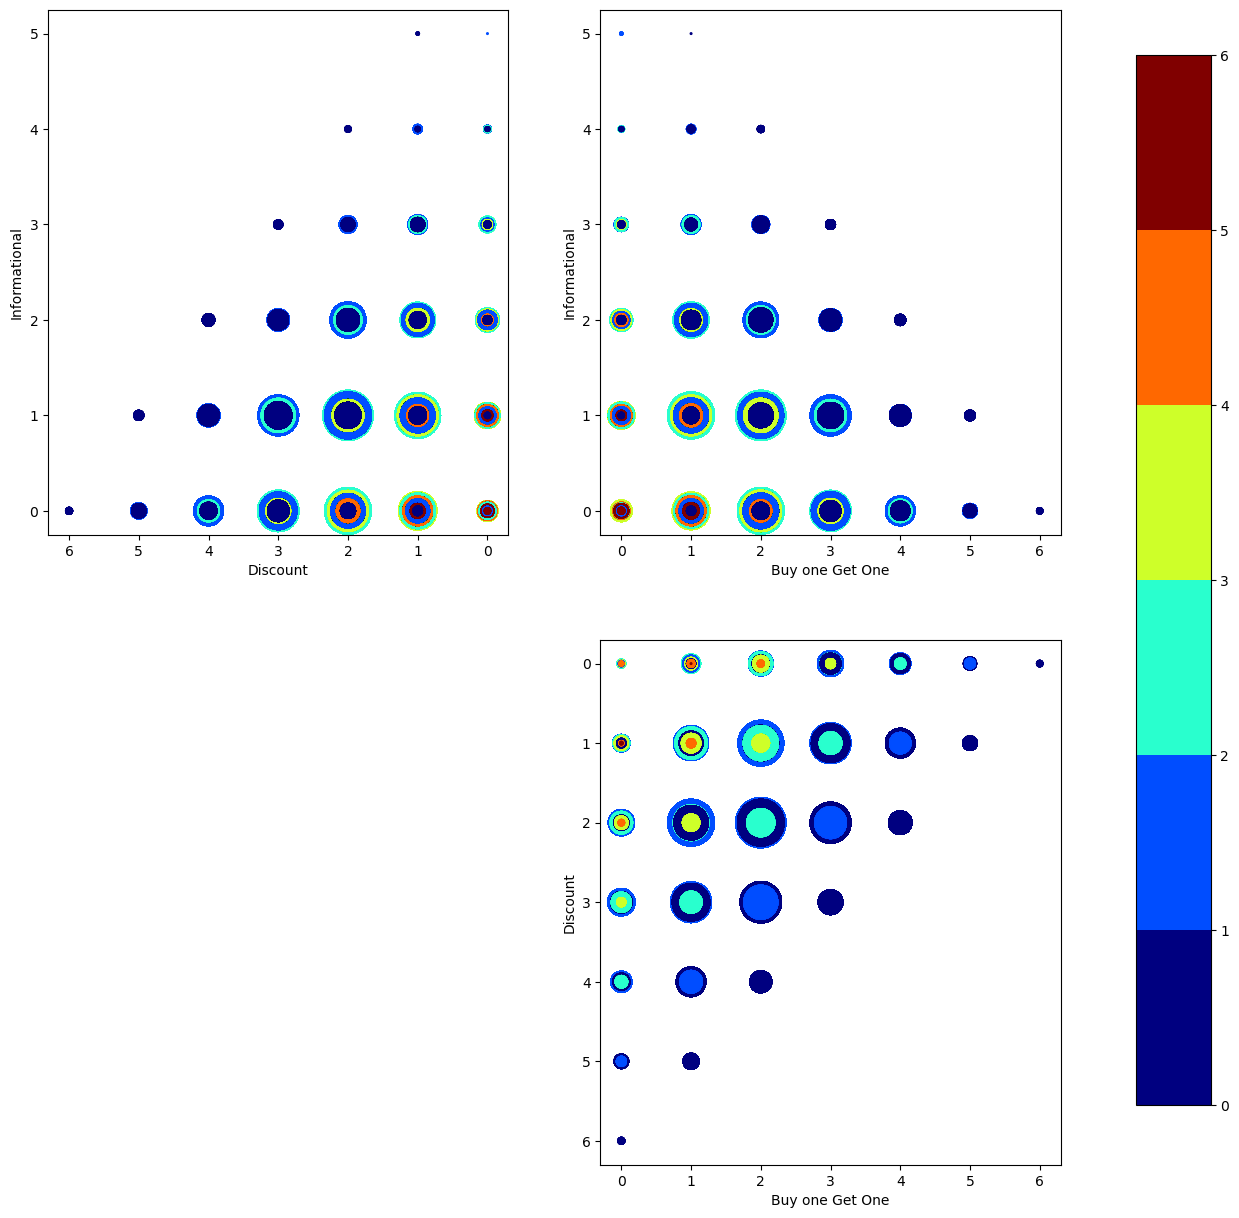

In [538]:
# #This plot shows the distrubution of the number of offer recieved

# Creates a dict used to map offerid to offertype
offer_2_type={x.Index: x.offer_type for x in portfolio.itertuples()}
offer_count = defaultdict(list)

# loop the dataset and for eah person count number of offers 
for name, person in tqdm(transcript[transcript['offer received']==1].groupby('person')):
    count=person['offer_index'].map(offer_2_type).value_counts()
    offer_count['discount'].append(count.get('discount', 0))
    offer_count['informational'].append(count.get('informational', 0))
    offer_count['bogo'].append(count.get('bogo',0))

bogo=offer_count['bogo']
informational=offer_count['informational']
discount=offer_count['discount']

# Set up the axes with gridspec
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(grid[:1, 1:])
ax2 = fig.add_subplot(grid[:-1, 0], sharey=ax1)
ax3 = fig.add_subplot(grid[-1, 1:], sharex=ax1)

# Set up the colors
cm = plt.cm.jet  # define the colormap
bounds = np.linspace(0, 6, 7)
norm = mpl.colors.BoundaryNorm(bounds, cm.N)

# Calculate marker size
xy = np.vstack([bogo,informational,discount])
marker_size = gaussian_kde(xy)(xy)*5000

# Scatter points on the three plots
# Sort the dots by the marker size, so the smallest isn't covered by the bigger ones
marker_size, discount, bogo, informational  = zip(*sorted(zip(marker_size, discount,bogo, informational),reverse=True))
cs1 = ax1.scatter(bogo, informational, s=marker_size, c=discount, cmap=cm, norm=norm)
ax2.scatter(discount, informational,  s=marker_size, c=bogo, cmap=cm, norm=norm)
ax3.scatter(bogo, discount,  s=marker_size, c=informational, cmap=cm, norm=norm)

# Set up colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cs1, cax=cbar_ax)

# Set labels
ax1.set_xlabel('Buy one Get One')
ax1.set_ylabel('Informational')
ax2.set_xlabel('Discount')
ax2.set_ylabel('Informational')
ax2.invert_xaxis()
ax3.set_xlabel('Buy one Get One')
ax3.set_ylabel('Discount')
ax3.invert_yaxis()


# next step. analyse the transaction in detail...
 we know that we have items where the user didn't look at the offer befor getting it, i.e didn't buy because of it.what we can do is maybe.
from the time the user look at it. but those user in one group (those with atleast one item at all time) and the rest in another group?
 or we actually also want to see how much the transaction increased AFTER the offer. how can we do that?

In [ ]:
# TODO this won't work anymore. need to redo if needed

have_offer=np.zeros((10,40*4))
have_offer_completed=np.zeros((10,40*4))
have_seen_offer=np.zeros((10,40*4))
have_seen_offer_completed=np.zeros((10,40*4))

#for i,(name, person) in enumerate(tqdm(transcript.dropna(subset=['offer_id']).groupby('person'))):
#    for offerid, group in person.groupby(['offer_index']):
for i,((name,offerid), group) in enumerate(tqdm(transcript.dropna(subset=['offer_id']).groupby(['person','offer_index']))):
    offerid = int(offerid)
    offer = portfolio.loc[offerid]
    viewed = 'offer viewed' in group['event'].values
    received_time = int(group.loc[group['event']=='offer received','time'].to_list()[0]/(24/4))
    end_time = int(received_time + offer['duration']*4)
    if 'offer completed' in group['event'].values:
        complete_time = int(group.loc[group['event']=='offer completed','time'].to_list()[0]/(24/4))
        if viewed:
            view_time = int(group.loc[group['event']=='offer viewed','time'].to_list()[0]/(24/4))
            have_seen_offer_completed[offerid,view_time:complete_time]+=1
        else:
            have_offer_completed[offerid,received_time:complete_time]+=1
    else:
        if viewed:
            view_time = int(group.loc[group['event']=='offer viewed','time'].to_list()[0]/(24/4))
            have_seen_offer[offerid,view_time:view_time+4]+=1
        else:
            have_offer[offerid,received_time:end_time]+=1

In [ ]:
# Todo
# this part was very early, it's a bit messy, and as for now I will probobly not use these plots
# If I doo, I also have to cahange the code as it's not correct anymore as it assumed
# that one user could only have one of each offer
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
for i in portfolio_my_order:
    label = "have_offer | " + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer[i,:], label=label);
plt.legend()
plt.show()
for i in portfolio_my_order:
    label = "have_offer_completed | " + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer_completed[i,:], label=label);
plt.legend()
plt.show()
for i in portfolio_my_order:
    label = "have_seen_offer | r" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer[i,:], label=label);
plt.legend()
plt.show()
for i in portfolio_my_order:
    label = "have_seen_offer_completed | " + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer_completed[i,:], label=label);
plt.legend()
plt.show()

In [ ]:
## Same as last cell, needs to be updated
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
for i in portfolio_my_order:
    label = "have_offer" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer[i,:], label=label);
    label = "have_offer_completed" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_offer_completed[i,:], label=label);
    label = "have_seen_offer" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer[i,:], label=label);
    label = "have_seen_offer_completed" + str(i) + str(portfolio.loc[i,['reward', 'difficulty', 'duration', 'offer_type']].values)
    plt.plot(have_seen_offer_completed[i,:], label=label);
    plt.legend()
    plt.show()

In [ ]:
#Todo, fix this one

#plot 10 x 6
unique_order = defaultdict(int)
person_offer_df = pd.DataFrame()
#fig, axs = plt.subplots(1, 1)
fig, axs = plt.subplots(4,2)
for j, rows in tqdm(transcript[transcript['offer received']==1].groupby('offer_burst')):
    for i, portfolio_i in enumerate(tqdm(portfolio_my_order)):
        print(json.dumps(unique_order, indent=4, sort_keys=True))
        this_rows = rows[rows['offer_index']==portfolio_i]
        this_offer = portfolio.loc[portfolio_i] 
        offer_index = portfolio_i     
        start_date = this_rows.iloc[0]['time'] # all in this group is the same start time, in hours
        end_date = start_date + this_offer.duration * 24 # in days, converted to hours
        
        persons_complete_notview=[]
        persons_notcomplete_notview=[]
        persons_notcomplete_view=[]
        persons_complete_view=[]
        
        
        for person_id in tqdm(set(this_rows['person'])):
            

            person_offer = transcript[(transcript['person']==person_id) & 
                                      (transcript['offer_index']==offer_index) & 
                                      (transcript['time']>=start_date) &
                                      (transcript['time']<= end_date)]

            unique_order[str(list(person_offer['event']))] +=1
            
            def find_and_cut(a):
                for i, x in enumerate(a[1:]):
                    if x == 'offer completed':
                        #print("a",i)
                        #display(person_offer)
                        return i+2
                    if x == 'offer received':
                        return i+1
                return None
            person_offer = person_offer.iloc[:find_and_cut(person_offer['event'])]
            
            # now each person offer contains one unique offer
            # however, there's some concerns:
            # I noted that one person can get the same offer before viewing/completed athe first
            # how to treat these? the same offer but reminder?
            # or will the user now have two offers that is "the same" offer_id. if so
            # what if we have the following
            # user get offer A, user oen offer A, user get offer B, user use offer A, the offer B
            # here we can't distinguish offer A from B(same id) this may be a edge case and perhaps we can just ignore this
            # so for now offer A will be terminated when we have offer B
            # if these is to be solved, we need to get the whole date range. and sort them out,
            
            oc=False
            ow=False

            for x in person_offer['event'][1:]:
                if x == 'offer completed':
                    oc=True
                elif x == 'offer viewed':
                    ow=True
            if oc and ow:
                persons_complete_view.append(person_id) 
            elif not oc and ow:
                persons_notcomplete_view.append(person_id) 
            elif not oc and not ow:
                persons_notcomplete_notview.append(person_id) 
            else:
                persons_complete_notview.append(person_id) 

            #take the transcript of this person & offerid betwen the date and this date+offer length
            #break
        if True: # Print TODO att try/catch here
            
            try: 
                this_profiles = profile[profile.index.isin(persons_notcomplete_notview)]
                this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[2,0])
                this_profiles['income'].plot(kind='kde', ax=axs[2,1])#[i,int(j)])
            except:
                pass
            try: 
                this_profiles = profile[profile.index.isin(persons_notcomplete_view)]
                this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[1,0])
                this_profiles['income'].plot(kind='kde', ax=axs[1,1])#[i,int(j)])
            except:
                pass
            try: 
                this_profiles = profile[profile.index.isin(persons_complete_view)]
                this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[0,0])
                this_profiles['income'].plot(kind='kde', ax=axs[0,1])#[i,int(j)])
            except:
                pass
            try: 
                this_profiles = profile[profile.index.isin(persons_complete_notview)]
                this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs[3,0])
                this_profiles['income'].plot(kind='kde', ax=axs[3,1])#[i,int(j)]
            except:
                pass

        #this_profiles[this_profiles['age'] != 118]['age'].plot(kind='kde', ax=axs)
       # display(this_rows)
        break
    break
        #this_profiles['income'].plot(kind='kde', ax=axs)#[i,int(j)])
            # here we will loop on the starts only!


A small "problem" is that we can get a new offer before the first one is ended. here's
a quick run over the them. this is within the time from the first "offer recieved" until validity date was out.
For the same person, and for the same offer id.
One scary case is these 
* ['offer received', 'offer viewed', 'offer received'] 
* ['offer received', 'offer received', 'offer viewed']
What if in both these cases, the second 'offer received' do have a offer complete, was that offer viewed or not?
is the answer in both cases be that the first was recieved but not opened, and not viewed, whereas the other 
was viewed and completed?

```{
    "['offer received', 'offer completed', 'offer received']": 13,
    "['offer received', 'offer completed', 'offer viewed', 'offer received', 'offer viewed']": 2,
    "['offer received', 'offer completed', 'offer viewed', 'offer received']": 11,
    "['offer received', 'offer completed', 'offer viewed']": 272,
    "['offer received', 'offer completed']": 216,
    "['offer received', 'offer received', 'offer completed', 'offer completed']": 1,
    "['offer received', 'offer received', 'offer viewed']": 2,
    "['offer received', 'offer received']": 34,
    "['offer received', 'offer viewed', 'offer completed', 'offer received', 'offer completed']": 5,
    "['offer received', 'offer viewed', 'offer completed', 'offer received', 'offer viewed']": 11,
    "['offer received', 'offer viewed', 'offer completed', 'offer received']": 53,
    "['offer received', 'offer viewed', 'offer completed']": 1687,
    "['offer received', 'offer viewed', 'offer received', 'offer completed', 'offer completed']": 2,
    "['offer received', 'offer viewed', 'offer received', 'offer viewed']": 7,
    "['offer received', 'offer viewed', 'offer received']": 66,
    "['offer received', 'offer viewed']": 2192,
    "['offer received']": 444
}```

count    16578.000000
mean       107.096874
std        126.393939
min          0.050000
25%         23.682500
50%         72.410000
75%        150.937500
max       1608.690000
dtype: float64

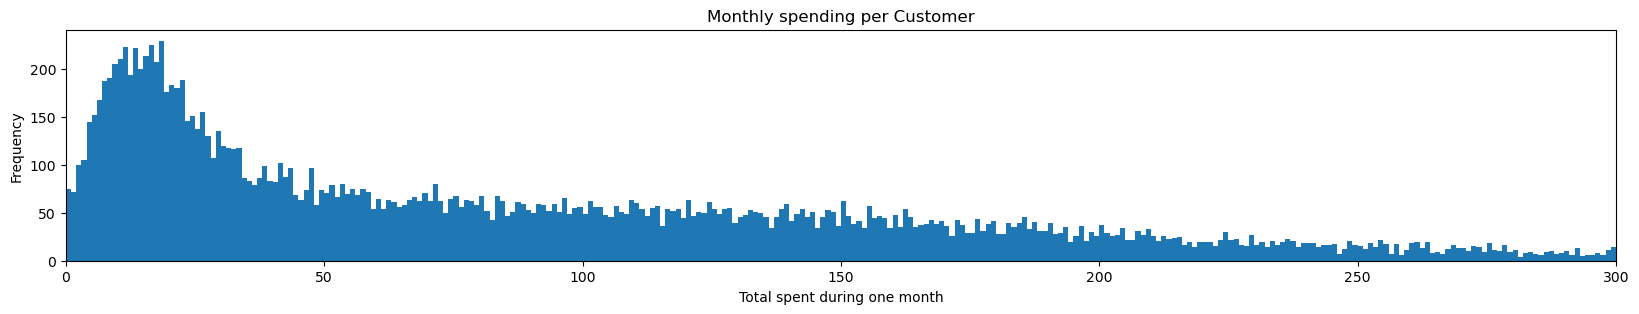

In [425]:
# From the transcript create a new dataframe that for each user
# contains the daily spending
person_transaction = transcript[transcript['event']=='transaction'].groupby([pd.Grouper(key='datetime', freq='D'),'person'])[['amount']].sum()
person_transaction = person_transaction.unstack(level=0).fillna(0)['amount']
ax = person_transaction.sum(axis=1).plot.hist(bins=np.arange(301),figsize=(20,3),xlim=(0,300),title='Monthly spending per Customer')
ax.set_xlabel("Total spent during one month")
person_transaction.sum(axis=1).describe()


In [354]:
#from a list of recieved, viewd and complete, how to link those together
#first belongs to first
# special cases
#start, start,view,endfirst,complete
# this could be:
# one start with view that was not complete and a start with no view but complete, however. this should be!!
# one start with no view, not complete, and a start with a view and a complete

# This takes some time to complete, so read a saved file instead if it exist

person_offer_df_file = 'data/person_offer.csv'
try:
    person_offer_df = pd.read_csv(person_offer_df_file)
except FileNotFoundError:
    #tqdm.pandas()

    person_offer_df = create_person_offer(transcript, portfolio, profile, person_transaction)

#     person_offer_df['before_start'] = 0
#     person_offer_df['same_day_start'] = 0
#     person_offer_df['after_start'] = 0
#     person_offer_df['before_view'] = 0
#     person_offer_df['same_day_view'] = 0
#     person_offer_df['after_view'] =0
#     person_offer_df['before_complete'] = 0
#     person_offer_df['same_day_complete']= 0
#     person_offer_df['after_complete'] = 0
#     person_offer_df['w_before'] = 0
#     person_offer_df['sum_during'] = 0
#     person_offer_df['mean_during'] = 0
#     person_offer_df['w_after'] = 0
#     person_offer_df = person_offer_df.progress_apply(get_before_after_mean,person_transaction=person_transaction , axis=1)    
    display(person_offer_df)
    person_offer_df.to_csv(person_offer_df_file, index_label=False)

person_offer_df.describe()


/home/lox/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



['person', 'offer', 'start', 'viewed_time', 'completed_time', 'viewed', 'completed', 'viewed_after', 'offer_burst', 'gender', 'age', 'became_member_on', 'income', 'reward', 'difficulty', 'duration', 'offer_type', 'id', 'mobile', 'social', 'web']


,person,offer,start,viewed_time,completed_time,viewed,completed,viewed_after,offer_burst,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,id,mobile,social,web,before_start,same_day_start,after_start,before_view,same_day_view,after_view,before_complete,same_day_complete,after_complete,w_before,sum_during,mean_during,w_after,viewed_reltime,completed_reltime,complete_viewed,complete_not_viewed,not_complete_not_viewed,not_complete_viewed,diff_start,diff_view,diff_complete,diff_offer,member_since_days
0,0009655768c64bdeb2e877511632db8f,2.0,336,372.0,NaN,1,0,0,2.0,M,33.0,2017-04-21,72000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1.582857,0.00,7.029333,1.477333,0.00,7.531429,0.000000,0.00,0.000000,1.332474,8.57,1.714000,0.000000,36.0,NaN,0,0,0,1,5.446476,6.054095,0.000000,-1.332474,461
1,0009655768c64bdeb2e877511632db8f,6.0,504,NaN,528.0,0,1,1,4.0,M,33.0,2017-04-21,72000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1.463333,0.00,12.108750,0.000000,0.00,0.000000,1.396818,14.11,11.822857,0.000000,0.00,0.000000,10.136097,NaN,24.0,0,1,0,0,10.645417,0.000000,10.426039,10.136097,461
2,0009655768c64bdeb2e877511632db8f,7.0,168,192.0,NaN,1,0,0,1.0,M,33.0,2017-04-21,72000.0,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0.000000,0.00,5.800000,0.000000,0.00,6.076190,0.000000,0.00,0.000000,0.000000,22.16,5.540000,0.000000,24.0,NaN,0,0,0,1,5.800000,6.076190,0.000000,0.000000,461
3,0009655768c64bdeb2e877511632db8f,8.0,408,NaN,414.0,0,1,1,3.0,M,33.0,2017-04-21,72000.0,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1.303529,8.57,8.072500,0.000000,0.00,0.000000,1.303529,8.57,8.072500,0.000000,0.00,0.000000,3.305085,NaN,6.0,0,1,0,0,6.768971,0.000000,6.768971,3.305085,461
4,0009655768c64bdeb2e877511632db8f,9.0,576,NaN,576.0,0,1,0,5.0,M,33.0,2017-04-21,72000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,2.433333,10.27,11.786000,0.000000,0.00,0.000000,2.433333,10.27,11.786000,0.000000,0.00,0.000000,8.082369,NaN,0.0,0,1,0,0,9.352667,0.000000,9.352667,8.082369,461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,4.0,168,174.0,198.0,1,1,0,1.0,F,45.0,2016-11-25,62000.0,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,4.622857,0.00,8.805000,4.622857,0.00,8.805000,4.045000,38.11,7.409524,4.313407,38.11,19.055000,10.416933,6.0,30.0,1,0,0,0,4.182143,4.182143,3.364524,6.103526,608
76273,ffff82501cea40309d5fdd7edcca4a07,6.0,0,6.0,60.0,1,1,0,0.0,F,45.0,2016-11-25,62000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0.000000,0.00,7.795517,0.000000,0.00,7.795517,0.000000,16.06,7.778148,0.000000,16.06,5.353333,7.191045,6.0,60.0,1,0,0,0,7.795517,7.795517,7.778148,7.191045,608
76274,ffff82501cea40309d5fdd7edcca4a07,9.0,336,354.0,384.0,1,1,0,2.0,F,45.0,2016-11-25,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,9.195000,0.00,6.489333,9.195000,0.00,6.489333,8.045625,15.57,6.290000,11.896334,15.57,5.190000,7.566869,18.0,48.0,1,0,0,0,-2.705667,-2.705667,-1.755625,-4.329465,608
76275,ffff82501cea40309d5fdd7edcca4a07,9.0,408,414.0,414.0,1,1,0,3.0,F,45.0,2016-11-25,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,8.488235,17.55,5.351667,8.488235,17.55,5.351667,8.488235,17.55,5.351667,8.888657,17.55,17.550000,4.130301,6.0,6.0,1,0,0,0,-3.136569,-3.136569,-3.136569,-4.758356,608


,offer,start,viewed_time,completed_time,viewed,completed,viewed_after,offer_burst,age,income,reward,difficulty,duration,mobile,social,web,before_start,same_day_start,after_start,before_view,same_day_view,after_view,before_complete,same_day_complete,after_complete,w_before,sum_during,mean_during,w_after,viewed_reltime,completed_reltime,complete_viewed,complete_not_viewed,not_complete_not_viewed,not_complete_viewed,diff_start,diff_view,diff_complete,diff_offer,member_since_days
count,76277.000000,76277.000000,52498.000000,33579.000000,76277.000000,76277.000000,76277.000000,76277.000000,66501.000000,66501.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,52498.000000,33579.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000
mean,4.495772,332.579519,348.926664,401.052801,0.688255,0.440224,0.068487,2.504897,54.369258,65371.618472,4.201607,7.707723,6.503704,0.899472,0.598909,0.799730,2.574032,3.995105,4.013430,1.689768,3.222393,2.878164,1.542685,10.296129,2.525084,1.732378,11.419644,4.851842,2.633874,22.474913,62.509783,0.309346,0.130878,0.180867,0.378908,1.439397,1.188396,0.982399,0.901496,517.035830
std,2.871179,196.489548,199.035118,192.352614,0.463209,0.496417,0.252582,1.707179,17.395430,21623.288473,3.398888,5.538203,2.201544,0.300705,0.490123,0.400205,4.700685,19.171267,6.762313,3.887048,16.614713,6.437418,3.708107,30.843280,6.609374,5.073444,30.199292,17.548470,7.678268,27.032312,51.475430,0.462227,0.337269,0.384911,0.485118,7.341277,6.528610,6.528189,8.734997,411.575257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-143.904610,-143.904610,-138.254481,-210.983965,0.000000
25%,2.000000,168.000000,180.000000,240.000000,0.000000,0.000000,0.000000,1.000000,42.000000,49000.000000,2.000000,5.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.652500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,24.000000,0.000000,0.000000,0.000000,0.000000,-0.362417,0.000000,0.000000,-0.585941,208.000000
50%,4.000000,408.000000,396.000000,432.000000,1.000000,0.000000,0.000000,3.000000,55.000000,64000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.010833,0.000000,2.257500,0.000000,0.000000,0.774667,0.000000,0.000000,0.000000,0.000000,3.540000,0.542727,0.000000,12.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.572069,0.000000,0.000000,0.000000,358.000000
75%,7.000000,504.000000,516.000000,564.000000,1.000000,1.000000,0.000000,4.000000,66.000000,80000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,3.692857,0.480000,5.471667,2.112500,0.000000,3.928621,1.949200,16.570000,3.463571,1.727267,16.750000,5.320000,2.934131,30.000000,96.000000,1.000000,0.000000,0.000000,1.000000,2.737990,1.606667,0.604596,1.278195,792.000000
max,9.000000,576.000000,714.000000,714.000000,1.000000,1.000000,1.000000,5.000000,101.000000,120000.000000,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,148.931429,881.350000,212.456000,148.931429,989.340000,386.605000,142.748571,1015.730000,488.890000,226.038842,1015.730000,989.340000,419.048571,264.000000,306.000000,1.000000,1.000000,1.000000,1.000000,208.165167,380.893519,478.026667,412.673115,1823.000000


In [370]:
# Now 
import seaborn as sns

# person_offer_df_file = 'data/person_offer_df_new4.csv'
# try:
#     person_offer_df = pd.read_csv(person_offer_df_file)
# except FileNotFoundError:
#     tqdm.pandas()
#     person_offer_df = person_offer_df.copy()
#     person_offer_df['before_start'] = 0
#     person_offer_df['same_day_start'] = 0
#     person_offer_df['after_start'] = 0
#     person_offer_df['before_view'] = 0
#     person_offer_df['same_day_view'] = 0
#     person_offer_df['after_view'] =0
#     person_offer_df['before_complete'] = 0
#     person_offer_df['same_day_complete']= 0
#     person_offer_df['after_complete'] = 0
#     person_offer_df['w_before'] = 0
#     person_offer_df['sum_during'] = 0
#     person_offer_df['mean_during'] = 0
#     person_offer_df['w_after'] = 0
#     person_offer_df = person_offer_df.progress_apply(get_before_after_mean,person_transaction=person_transaction , axis=1)    
#     display(person_offer_df)
#     person_offer_df.to_csv(person_offer_df_file, index_label=False)

plt.figure(figsize=(35,35))
plot heat map
display(person_offer_df)
g=sns.heatmap(person_offer_df.corr(),annot=True,cmap="RdYlGn")

True


,start,viewed_time,completed_time,viewed,completed,viewed_after,offer_burst,offer,age,income,reward,difficulty,duration,mobile,social,web,before_start,same_day_start,after_start,before_view,same_day_view,after_view,before_complete,same_day_complete,after_complete,w_before,sum_during,mean_during,w_after,viewed_reltime,completed_reltime,complete_viewed,complete_not_viewed,not_complete_not_viewed,not_complete_viewed,diff_start,diff_view,diff_complete,diff_offer,member_since_days
count,76277.000000,52498.000000,33579.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,66501.000000,66501.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,52498.000000,33579.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000
mean,332.579519,348.926664,401.052801,0.688255,0.440224,0.068487,2.504897,4.495772,54.369258,65371.618472,4.201607,7.707723,6.503704,0.899472,0.598909,0.799730,2.574032,3.995105,4.013430,1.689768,3.222393,2.878164,1.542685,10.296129,2.525084,1.732378,11.419644,4.851842,2.633874,22.474913,62.509783,0.309346,0.130878,0.180867,0.378908,1.439397,1.188396,0.982399,0.901496,517.035830
std,196.489548,199.035118,192.352614,0.463209,0.496417,0.252582,1.707179,2.871179,17.395430,21623.288473,3.398888,5.538203,2.201544,0.300705,0.490123,0.400205,4.700685,19.171267,6.762313,3.887048,16.614713,6.437418,3.708107,30.843280,6.609374,5.073444,30.199292,17.548470,7.678268,27.032312,51.475430,0.462227,0.337269,0.384911,0.485118,7.341277,6.528610,6.528189,8.734997,411.575257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-143.904610,-143.904610,-138.254481,-210.983965,0.000000
25%,168.000000,180.000000,240.000000,0.000000,0.000000,0.000000,1.000000,2.000000,42.000000,49000.000000,2.000000,5.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.652500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,24.000000,0.000000,0.000000,0.000000,0.000000,-0.362417,0.000000,0.000000,-0.585941,208.000000
50%,408.000000,396.000000,432.000000,1.000000,0.000000,0.000000,3.000000,4.000000,55.000000,64000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.010833,0.000000,2.257500,0.000000,0.000000,0.774667,0.000000,0.000000,0.000000,0.000000,3.540000,0.542727,0.000000,12.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.572069,0.000000,0.000000,0.000000,358.000000
75%,504.000000,516.000000,564.000000,1.000000,1.000000,0.000000,4.000000,7.000000,66.000000,80000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,3.692857,0.480000,5.471667,2.112500,0.000000,3.928621,1.949200,16.570000,3.463571,1.727267,16.750000,5.320000,2.934131,30.000000,96.000000,1.000000,0.000000,0.000000,1.000000,2.737990,1.606667,0.604596,1.278195,792.000000
max,576.000000,714.000000,714.000000,1.000000,1.000000,1.000000,5.000000,9.000000,101.000000,120000.000000,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,148.931429,881.350000,212.456000,148.931429,989.340000,386.605000,142.748571,1015.730000,488.890000,226.038842,1015.730000,989.340000,419.048571,264.000000,306.000000,1.000000,1.000000,1.000000,1.000000,208.165167,380.893519,478.026667,412.673115,1823.000000


,start,viewed_time,completed_time,viewed,completed,viewed_after,offer_burst,offer,age,income,reward,difficulty,duration,mobile,social,web,before_start,same_day_start,after_start,before_view,same_day_view,after_view,before_complete,same_day_complete,after_complete,w_before,sum_during,mean_during,w_after,viewed_reltime,completed_reltime,complete_viewed,complete_not_viewed,not_complete_not_viewed,not_complete_viewed,diff_start,diff_view,diff_complete,diff_offer,member_since_days
count,76277.000000,52498.000000,33579.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,66501.000000,66501.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,52498.000000,33579.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000,76277.000000
mean,332.579519,348.926664,401.052801,0.688255,0.440224,0.068487,2.504897,4.495772,54.369258,65371.618472,4.201607,7.707723,6.503704,0.899472,0.598909,0.799730,2.574032,3.995105,4.013430,1.689768,3.222393,2.878164,1.542685,10.296129,2.525084,1.732378,11.419644,4.851842,2.633874,22.474913,62.509783,0.309346,0.130878,0.180867,0.378908,1.439397,1.188396,0.982399,0.901496,517.035830
std,196.489548,199.035118,192.352614,0.463209,0.496417,0.252582,1.707179,2.871179,17.395430,21623.288473,3.398888,5.538203,2.201544,0.300705,0.490123,0.400205,4.700685,19.171267,6.762313,3.887048,16.614713,6.437418,3.708107,30.843280,6.609374,5.073444,30.199292,17.548470,7.678268,27.032312,51.475430,0.462227,0.337269,0.384911,0.485118,7.341277,6.528610,6.528189,8.734997,411.575257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-143.904610,-143.904610,-138.254481,-210.983965,0.000000
25%,168.000000,180.000000,240.000000,0.000000,0.000000,0.000000,1.000000,2.000000,42.000000,49000.000000,2.000000,5.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.652500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,24.000000,0.000000,0.000000,0.000000,0.000000,-0.362417,0.000000,0.000000,-0.585941,208.000000
50%,408.000000,396.000000,432.000000,1.000000,0.000000,0.000000,3.000000,4.000000,55.000000,64000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.010833,0.000000,2.257500,0.000000,0.000000,0.774667,0.000000,0.000000,0.000000,0.000000,3.540000,0.542727,0.000000,12.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.572069,0.000000,0.000000,0.000000,358.000000
75%,504.000000,516.000000,564.000000,1.000000,1.000000,0.000000,4.000000,7.000000,66.000000,80000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,3.692857,0.480000,5.471667,2.112500,0.000000,3.928621,1.949200,16.570000,3.463571,1.727267,16.750000,5.320000,2.934131,30.000000,96.000000,1.000000,0.000000,0.000000,1.000000,2.737990,1.606667,0.604596,1.278195,792.000000
max,576.000000,714.000000,714.000000,1.000000,1.000000,1.000000,5.000000,9.000000,101.000000,120000.000000,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,148.931429,881.350000,212.456000,148.931429,989.340000,386.605000,142.748571,1015.730000,488.890000,226.038842,1015.730000,989.340000,419.048571,264.000000,306.000000,1.000000,1.000000,1.000000,1.000000,208.165167,380.893519,478.026667,412.673115,1823.000000


ValueError: Can only compare identically-labeled Series objects

Text(0.5, 0, 'Average weighted spending before/after an offer')

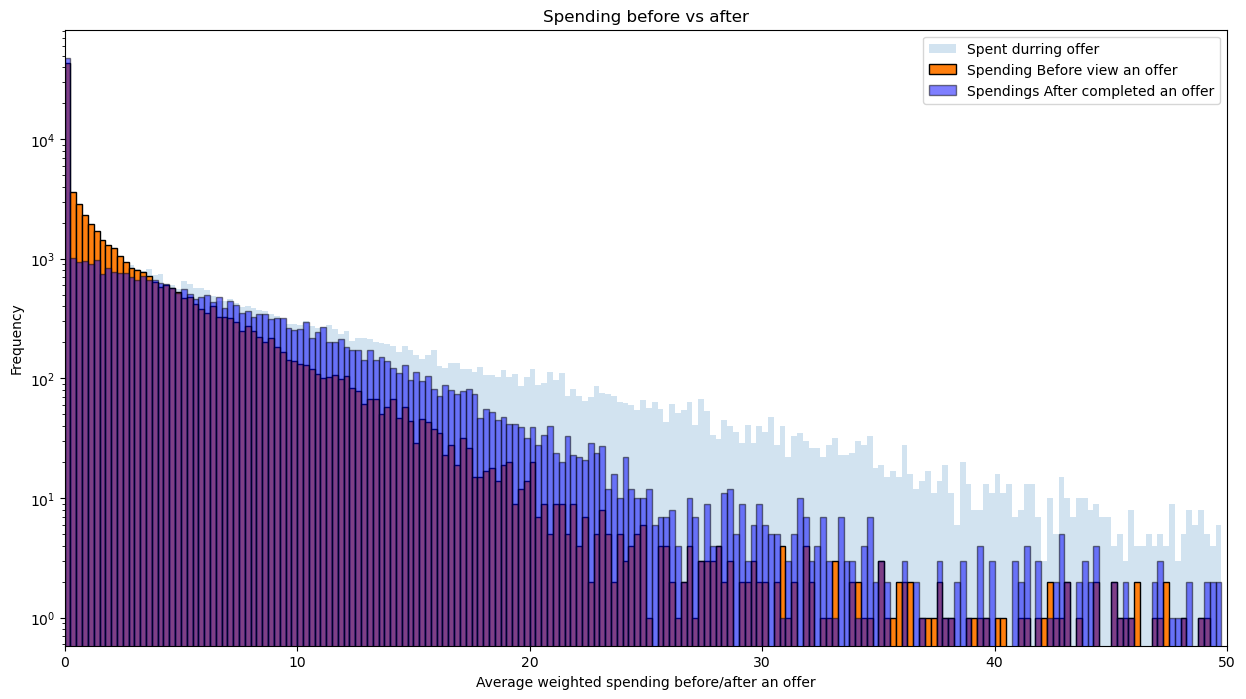

In [548]:
#ax=person_offer_df['diff_complete'].plot.kde(xlim=(-15,15),label="complete",figsize=(15,15))
#ax=person_offer_df['diff_start'].plot.kde(xlim=(-15,15),label="start")
#ax=person_offer_df['diff_view'].plot.kde(xlim=(-15,15),label="view")
ax=person_offer_df['mean_during'].plot.hist(bins=np.arange(0,50,0.25),label="Spent durring offer",alpha=0.2)
ax=person_offer_df['w_before'].plot.hist(bins=np.arange(0,50,0.25),xlim=(0,50),title='Spending before vs after',edgecolor='black',label="Spending Before view an offer",figsize=(15,8),alpha=1,log=True)
ax=person_offer_df['w_after'].plot.hist(bins=np.arange(0,50,0.25),label="Spendings After completed an offer",alpha=0.5,edgecolor='black',color='b')

ax.legend()
ax.set_xlabel("Average weighted spending before/after an offer")
#ax.set_xticks( xtick, minor=True 
#ax.grid(True, which="both", ls="-")
#ax.grid('on', which='major', axis='y' )
#ax.grid('on', which='major', axis='x' )

In [ ]:
# add columns that is aggregation of other columns
person_offer_df['complete_viewed'] = person_offer_df['completed'] & person_offer_df['viewed']
person_offer_df['complete_not_viewed'] = person_offer_df['completed'] & ~person_offer_df['viewed']
person_offer_df['not_complete_not_viewed'] = ~person_offer_df['completed'] & ~person_offer_df['viewed']
person_offer_df['not_complete_viewed'] = ~person_offer_df['completed'] & person_offer_df['viewed']

# Create a dataframe average_per_person

Same as person_offer_df but mean for each customer

In [405]:
## now callapes the person_offer_df into one row per person, and average alle the rows.
# but first, by doing mean, we will remove non-numerical values, so turn these into categories
# and then back ( as we do need them later too


person_offer_df2 = pd.concat([person_offer_df, pd.get_dummies(person_offer_df['duration'], prefix='duration', prefix_sep='_', drop_first=False, dummy_na=False)],axis=1) 
person_offer_df2 = pd.concat([person_offer_df2, pd.get_dummies(person_offer_df2['gender'], prefix='', prefix_sep='', drop_first=False, dummy_na=True)], axis=1)
#Create average_per_person
average_per_person = person_offer_df2.groupby('person').mean()
average_per_person['gender'] = average_per_person[['M','F','O','nan']].idxmax(axis=1,skipna=False).replace('nan',np.nan)
average_per_person.drop(columns=['nan'], inplace=True)

## Analyse the new person offer DataFrame

Do density plots over age and income for eah of the groups depending on what users viewd/completed an offer

(10.0, 110.0)

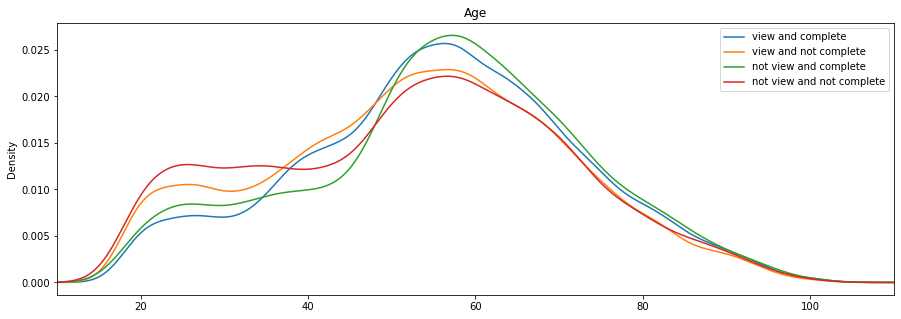

In [406]:
viewed = person_offer_df['viewed'].astype(bool)
completed = person_offer_df['completed'].astype(bool)
ageok = person_offer_df['age'] != 118

ax = person_offer_df[viewed & completed & ageok]['age'].plot.density(label='view and complete', figsize=(15,5),title='Age')
person_offer_df[viewed & ~completed & ageok]['age'].plot.density(ax=ax, label='view and not complete')
person_offer_df[~viewed & completed & ageok]['age'].plot.density(ax=ax, label='not view and complete')
person_offer_df[~viewed & ~completed & ageok]['age'].plot.density(ax=ax, label='not view and not complete')
ax.legend()
ax.set_xlim(10,110)

(20000.0, 130000.0)

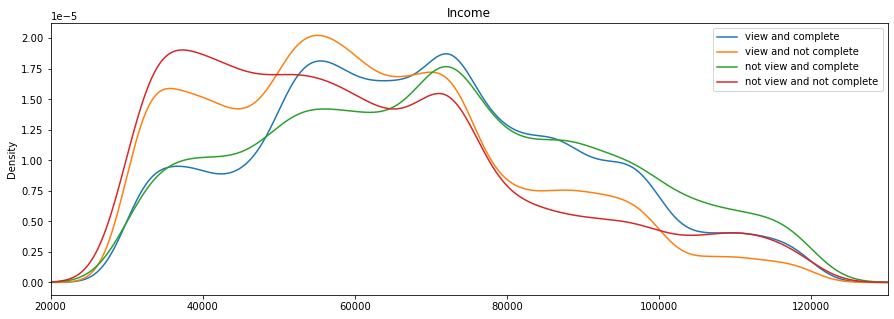

In [407]:
ax = person_offer_df[viewed & completed]['income'].plot.density(label='view and complete', figsize=(15,5),title='Income')
person_offer_df[viewed & ~completed]['income'].plot.density(ax=ax, label='view and not complete')
person_offer_df[~viewed & completed]['income'].plot.density(ax=ax, label='not view and complete')
person_offer_df[~viewed & ~completed]['income'].plot.density(ax=ax, label='not view and not complete')
ax.legend()
ax.set_xlim(20000,130000)

In [408]:
person_offer_df[person_offer_df['viewed']==True]

,start,viewed_time,completed_time,viewed,completed,viewed_after,offer_burst,person,offer,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,id,mobile,social,web,before_start,same_day_start,after_start,before_view,same_day_view,after_view,before_complete,same_day_complete,after_complete,w_before,sum_during,mean_during,w_after,viewed_reltime,completed_reltime,complete_viewed,complete_not_viewed,not_complete_not_viewed,not_complete_viewed,diff_start,diff_view,diff_complete,diff_offer,member_since_days
0,336,372.0,NaN,1,0,0,2.0,0009655768c64bdeb2e877511632db8f,2.0,M,33.0,2017-04-21,72000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1.582857,0.00,7.029333,1.477333,0.00,7.531429,0.000000,0.00,0.000000,1.332474,8.57,1.714000,0.000000,36.0,NaN,0,0,0,1,5.446476,6.054095,0.000000,-1.332474,461
2,168,192.0,NaN,1,0,0,1.0,0009655768c64bdeb2e877511632db8f,7.0,M,33.0,2017-04-21,72000.0,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0.000000,0.00,5.800000,0.000000,0.00,6.076190,0.000000,0.00,0.000000,0.000000,22.16,5.540000,0.000000,24.0,NaN,0,0,0,1,5.800000,6.076190,0.000000,0.000000,461
5,168,216.0,NaN,1,0,0,1.0,00116118485d4dfda04fdbaba9a87b5c,8.0,None,NaN,2018-04-25,NaN,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0.000000,0.00,0.185909,0.000000,0.00,0.204500,0.000000,0.00,0.000000,0.000000,0.70,0.116667,0.000000,48.0,NaN,0,0,0,1,0.185909,0.204500,0.000000,0.000000,92
6,576,630.0,NaN,1,0,0,5.0,00116118485d4dfda04fdbaba9a87b5c,8.0,None,NaN,2018-04-25,NaN,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0.170417,0.00,0.000000,0.157308,0.00,0.000000,0.000000,0.00,0.000000,0.155082,0.00,0.000000,0.000000,54.0,NaN,0,0,0,1,-0.170417,-0.157308,0.000000,-0.155082,92
7,0,6.0,NaN,1,0,0,0.0,0011e0d4e6b944f998e987f904e8c1e5,2.0,O,40.0,2018-01-09,57000.0,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,0.000000,0.00,2.740000,0.000000,0.00,2.740000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,6.0,NaN,0,0,0,1,2.740000,2.740000,0.000000,0.000000,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76270,408,510.0,516.0,1,1,0,3.0,fffad4f4828548d1b5583907f2e9906b,8.0,M,34.0,2017-01-23,34000.0,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,2.978824,0.00,3.182500,2.411429,12.18,3.251250,2.411429,12.18,3.251250,1.085163,12.18,12.180000,3.725545,102.0,108.0,1,0,0,0,0.203676,0.839821,0.839821,2.640381,549
76272,168,174.0,198.0,1,1,0,1.0,ffff82501cea40309d5fdd7edcca4a07,4.0,F,45.0,2016-11-25,62000.0,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,4.622857,0.00,8.805000,4.622857,0.00,8.805000,4.045000,38.11,7.409524,4.313407,38.11,19.055000,10.416933,6.0,30.0,1,0,0,0,4.182143,4.182143,3.364524,6.103526,608
76273,0,6.0,60.0,1,1,0,0.0,ffff82501cea40309d5fdd7edcca4a07,6.0,F,45.0,2016-11-25,62000.0,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0.000000,0.00,7.795517,0.000000,0.00,7.795517,0.000000,16.06,7.778148,0.000000,16.06,5.353333,7.191045,6.0,60.0,1,0,0,0,7.795517,7.795517,7.778148,7.191045,608
76274,336,354.0,384.0,1,1,0,2.0,ffff82501cea40309d5fdd7edcca4a07,9.0,F,45.0,2016-11-25,62000.0,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,9.195000,0.00,6.489333,9.195000,0.00,6.489333,8.045625,15.57,6.290000,11.896334,15.57,5.190000,7.566869,18.0,48.0,1,0,0,0,-2.705667,-2.705667,-1.755625,-4.329465,608


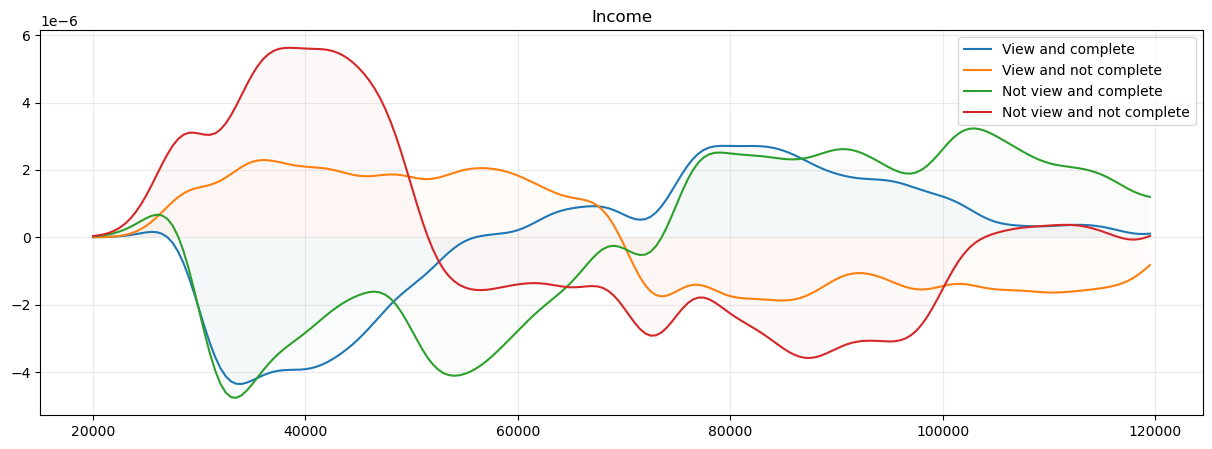

In [409]:
# These plots above is showing pretty good, but what if we substact the density for all,
# then it will be even easier to see.
nvc = person_offer_df[~viewed & completed].dropna(subset=['income'])
vc = person_offer_df[viewed & completed].dropna(subset=['income'])
vnc = person_offer_df[viewed & ~completed].dropna(subset=['income'])
nvnc = person_offer_df[~viewed & ~completed].dropna(subset=['income'])
total = person_offer_df.dropna(subset=['income'])
import scipy
nvc_kde=scipy.stats.gaussian_kde(nvc['income'])
vc_kde=scipy.stats.gaussian_kde(vc['income'])
vnc_kde=scipy.stats.gaussian_kde(vnc['income'])
nvnc_kde=scipy.stats.gaussian_kde(nvnc['income'])
totkde=scipy.stats.gaussian_kde(total['income'])
import matplotlib as mpl; mpl.style.use('default')
grid = range(20000,120000,500)
ax = plt.figure(figsize=(15,5)).add_subplot(111,title='Income')
plt.plot(grid, vc_kde(grid) - (totkde(grid)),label='View and complete')
plt.plot(grid, vnc_kde(grid) - (totkde(grid)),label='View and not complete')
plt.plot(grid, nvc_kde(grid) - (totkde(grid)),label='Not view and complete')
plt.plot(grid, nvnc_kde(grid) - (totkde(grid)),label='Not view and not complete')
plt.fill_between(grid,vc_kde(grid) - totkde(grid),alpha=0.025)
plt.fill_between(grid,vnc_kde(grid) - (totkde(grid)),alpha=0.025)
plt.fill_between(grid,nvc_kde(grid) - (totkde(grid)),alpha=0.025)
plt.fill_between(grid,nvnc_kde(grid) - totkde(grid),alpha=0.025)
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

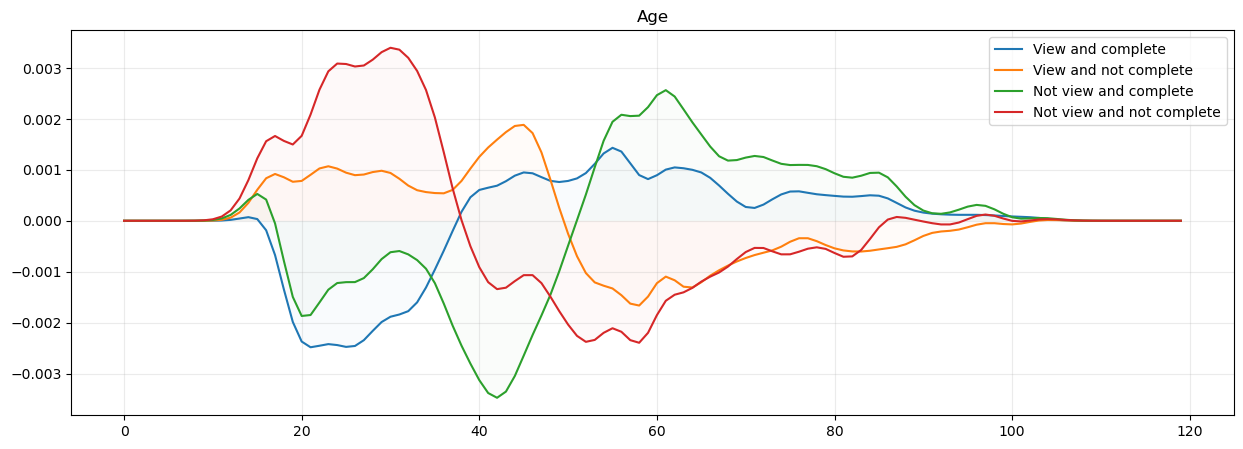

In [410]:
# Same as above but for age
nvc_kde=scipy.stats.gaussian_kde(nvc['age'])
vc_kde=scipy.stats.gaussian_kde(vc['age'])
vnc_kde=scipy.stats.gaussian_kde(vnc['age'])
nvnc_kde=scipy.stats.gaussian_kde(nvnc['age'])
totkde=scipy.stats.gaussian_kde(total['age'])
grid = range(0,120,1)
ax = plt.figure(figsize=(15,5)).add_subplot(111,title='Age')
plt.plot(grid, vc_kde(grid) - (totkde(grid)),label='View and complete')
plt.plot(grid, vnc_kde(grid) - (totkde(grid)),label='View and not complete')
plt.plot(grid, nvc_kde(grid) - (totkde(grid)),label='Not view and complete')
plt.plot(grid, nvnc_kde(grid) - (totkde(grid)),label='Not view and not complete')
plt.fill_between(grid,vc_kde(grid) - totkde(grid),alpha=0.025)
plt.fill_between(grid,vnc_kde(grid) - (totkde(grid)),alpha=0.025)
plt.fill_between(grid,nvc_kde(grid) - (totkde(grid)),alpha=0.025)
plt.fill_between(grid,nvnc_kde(grid) - totkde(grid),alpha=0.025)
plt.grid(True, alpha=0.25)
plt.legend()
plt.show


The cells below this do make cool plots. It do show the relationship between age and income and how it affects the customer to complete an offer.
So it do give lots of information, but don't think it actually give much more than what we can see above. and as we can't plot together, it would be lots of plots, looking about the same and it's not as easy to see as the ones above.

In [549]:
## do a nice matrix of 2d density TODO
# 2*4 plots,  each gender side by side, use _tr for this
for gender in ['M','F','O']:
    nvc = person_offer_df[~viewed & completed].dropna(subset=['income'])
    vc = person_offer_df[viewed & completed].dropna(subset=['income'])
    vnc = person_offer_df[viewed & ~completed].dropna(subset=['income'])
    nvnc = person_offer_df[~viewed & ~completed].dropna(subset=['income'])
    total = person_offer_df.dropna(subset=['income'])

In [ ]:
nvc = person_offer_df[~viewed & completed].dropna(subset=['income'])
vc = person_offer_df[viewed & completed].dropna(subset=['income'])
vnc = person_offer_df[viewed & ~completed].dropna(subset=['income'])
nvnc = person_offer_df[~viewed & ~completed].dropna(subset=['income'])
total = person_offer_df.dropna(subset=['income'])

nvc_kde=scipy.stats.gaussian_kde([nvc['age'],nvc['income']])
vc_kde=scipy.stats.gaussian_kde([vc['age'],vc['income']])
vnc_kde=scipy.stats.gaussian_kde([vnc['age'],vnc['income']])
nvnc_kde=scipy.stats.gaussian_kde([nvnc['age'],nvnc['income']])
totkde=scipy.stats.gaussian_kde([total['age'],total['income']])

# Peform the kernel density estimate
xx, yy = np.mgrid[0:100:1, 20000:120000:1000j]
positions = np.vstack([xx.ravel(), yy.ravel()])

f = np.reshape(nvc_kde(positions).T, xx.shape)
ftot = np.reshape(totkde(positions).T, xx.shape)
f=f-ftot
grid = positions
fig = plt.figure()
ax = fig.gca()
ax.contourf(xx, yy, f, cmap='Blues')

In [ ]:
# Peform the kernel density estimate
xx, yy = np.mgrid[0:100:1, 20000:120000:1000j]
positions = np.vstack([xx.ravel(), yy.ravel()])

f = np.reshape(vc_kde(positions).T, xx.shape)
ftot = np.reshape(totkde(positions).T, xx.shape)
f=f-ftot
grid = positions
fig = plt.figure()
ax = fig.gca()
ax.contourf(xx, yy, f, cmap='Blues')

In [ ]:
# Peform the kernel density estimate
xx, yy = np.mgrid[0:100:1, 20000:120000:1000j]
positions = np.vstack([xx.ravel(), yy.ravel()])

f = np.reshape(vnc_kde(positions).T, xx.shape)
ftot = np.reshape(totkde(positions).T, xx.shape)
f=f-ftot
grid = positions
fig = plt.figure()
ax = fig.gca()
ax.contourf(xx, yy, f, cmap='Blues')

In [ ]:
# Peform the kernel density estimate
xx, yy = np.mgrid[0:100:1, 20000:120000:1000j]
positions = np.vstack([xx.ravel(), yy.ravel()])

f = np.reshape(nvnc_kde(positions).T, xx.shape)
ftot = np.reshape(totkde(positions).T, xx.shape)
f=f-ftot
grid = positions
fig = plt.figure()
ax = fig.gca()
ax.contourf(xx, yy, f, cmap='Blues')

In [ ]:
# and finaly show how different gender view/complete offers.
# TODO, how to get these plot nicer?? it's impossible to plot it even...
ax = person_offer_df[viewed & completed]['gender'].value_counts().plot.bar(label='view and complete',position=-0.8, width = 0.1, color='C0',alpha=0.8, figsize=(15,10),title='Gender')
person_offer_df[viewed & ~completed]['gender'].value_counts().plot.bar(ax=ax, label='view and not complete',position=0, width = 0.1, color='C1',alpha=0.8)
person_offer_df[~viewed & completed]['gender'].value_counts().plot.bar(ax=ax, label='not view and complete',position=0.8, width = 0.1, color='C2',alpha=0.8)
person_offer_df[~viewed & ~completed]['gender'].value_counts().plot.bar(ax=ax, label='not view and not complete',position=1.6, width = 0.1, color='C3',alpha=0.8)
ax.legend()

## Analyse person_transaction

In the cells below we can clearly see that the price is indeed going up with time. But not really intersting as is

In [ ]:
person_transaction.mean().plot()

In [ ]:
#so to make some more out of this, seperate into groups based om number of offers
count_offers = person_offer_df.groupby('person')['person'].count()
count_offers.head(10)

# look into person_offer_df

In [ ]:
person_offer_df

In [ ]:
average_per_person.describe()

# Look into average_per_person

In [ ]:
print(list(average_per_person))
import seaborn as sns
data = average_per_person#[['complete_viewed', 'income','gender']]
#average_per_person.plot(x='complete_viewed', y='income', style='o')
#apply tanh to diff
sns.jointplot(x=data['diff_complete'], y=data['before_start'], kind='kde', ylim=(0,10))
#sns.jointplot(x=data['diff_complete'], y=data['age'], kind='kde')#, xlim=(-10,10))

In [ ]:
# Create a pair plot colored by continent with a density plot of the # diagonal and format the scatter plots.
import seaborn as sns
data = average_per_person[['complete_viewed', 'income','gender']]
sns.pairplot(data, hue = 'gender', diag_kind = 'kde',
             plot_kws = {'alpha': 0.2, 's': 80, 'edgecolor': 'k'},
             size = 4)

In [ ]:
#average_per_person[[M','gender_F','gender_O']].idxmax(axis=1,skipna=False)
#df.columns = df.columns.str.replace(r"[()]", "_")

## fix person_offer_df with correct datatypes etc

# ML Part

Do Some machine learning now! we could for example do:

* Predict if someone will view and complete
* predict if someone just complete
* predict how much user wil buy after


Whar features to use?

In [ ]:

person_offer_df = person_offer_df.loc[:,~person_offer_df.columns.duplicated()]
person_offer_df.head()

First try to do multiclassification in the 4 combination od view and complete

In [ ]:

#single label
#model = LogisticRegression(random_state=42)
#model = GaussianNB()
#model = xgb.XGBClassifier()
models =[KNeighborsClassifier(),
ExtraTreesClassifier(max_features = 12, min_samples_leaf = 75, n_estimators =500,class_weight='balanced'),
RandomForestClassifier(max_features = 11, min_samples_leaf = 75, n_estimators =500,class_weight='balanced')]
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
for model in models:
    print(f"#############################{'#'*len(model.__class__.__name__)}##############################")
    print(f" #######################     {' '*len(model.__class__.__name__)}    ###########################")
    print(f"  ####################       {model.__class__.__name__}      ##########################")
    print(f"   #####################     {' '*len(model.__class__.__name__)}    #############################")
    print(f"    #########################{'#'*len(model.__class__.__name__)}##################################")
    #used different amount in the grid search
    #parameters = { 'max_features':[6,9,12,15],'n_estimators':[100,250,500],'min_samples_leaf': [50,75,100]}
    #model = GridSearchCV(model, parameters, cv = 3, verbose=3)

    x_cols = ['F','M',
        'reward','difficulty','before_start','mobile','social','web',
           'duration_4', 'duration_5', 'duration_7', 
             'offer_type_bogo','offer_type_discount','offer_type_informational']

    x_convert_to_cat = [('age',10),('income',10),('member_since_days',10)]
    y_cols = ['complete_viewed','complete_not_viewed','not_complete_not_viewed','not_complete_viewed'] #,'diff_view','diff_complete']
    
    X_train, X_test, y_train, y_test, x_cols = prepare_data(person_offer_df,y_cols, x_cols, x_convert_to_cat)
    model, y_test_preds, y_train_preds,y_test_proba, y_train_proba = train_model(model, X_train,y_train, X_test,  y_test)
    
    print("#####################################################")
    print()
    print('acc train:', accuracy_score(y_true=y_train, y_pred=y_train_preds))
    print('acc test:', accuracy_score(y_true=y_test, y_pred=y_test_preds))
    
    print('f1 train:', f1_score(y_true=y_train, y_pred=y_train_preds, average='weighted'))
    print('f1 test:',f1_score(y_true=y_test, y_pred=y_test_preds, average='weighted'))

    #print_classification_report(y_train,y_test,y_train_preds,y_test_preds)
    printRocCurves(y_test,y_test_proba, y_cols)
    plot_cmatrix(y_test, y_test_preds, y_cols)
    #print_feature_importance(model, x_cols)
    print("#####################################################")

In [ ]:
#single label
#model = LogisticRegression(random_state=42,class_weight='balanced')
#model = GaussianNB(class_weight='balanced')
#model = xgb.XGBClassifier()
models =[XGBClassifier(class_weight='balanced')]
# KNeighborsClassifier(),
# ExtraTreesClassifier(max_features = 12, min_samples_leaf = 75, n_estimators =500,class_weight='balanced'),
# RandomForestClassifier(max_features = 11, min_samples_leaf = 75, n_estimators =500,class_weight='balanced')]
from sklearn.metrics import f1_score
for model in models:
    print(f"#############################{'#'*len(model.__class__.__name__)}##############################")
    print(f" #######################     {' '*len(model.__class__.__name__)}    ###########################")
    print(f"  ####################       {model.__class__.__name__}      ##########################")
    print(f"   #####################     {' '*len(model.__class__.__name__)}    #############################")
    print(f"    #########################{'#'*len(model.__class__.__name__)}##################################")
    x_convert_to_cat = [('age',10),('income',10),('member_since_days',10)]
    y_cols2 = ['complete_viewed','complete_not_viewed','not_complete_not_viewed','not_complete_viewed'] #,'diff_view','diff_complete']
    for y_cols in y_cols2:    
        x_cols = ['F','M','reward','difficulty','before_start','mobile','social','web','duration_4', 'duration_5',
                  'duration_7','offer_type_bogo','offer_type_discount','offer_type_informational']

        y_cols = [y_cols]
        X_train, X_test, y_train, y_test, x_cols = prepare_data(person_offer_df,y_cols, x_cols, x_convert_to_cat)
        model, y_test_preds, y_train_preds,y_test_proba, y_train_proba = train_model(model, X_train, y_train,X_test,  y_test)
        
        print(f"########################{y_cols}#############################")
        print()
        print('acc train:', accuracy_score(y_true=y_train, y_pred=y_train_preds))
        print('acc test:', accuracy_score(y_true=y_test, y_pred=y_test_preds))

        print('f1 train:', f1_score(y_true=y_train, y_pred=y_train_preds, average='weighted'))
        print('f1 test:',f1_score(y_true=y_test, y_pred=y_test_preds, average='weighted'))
        #print_classification_report(y_train,y_test,y_train_preds,y_test_preds)
        printRocCurves(y_test,y_test_proba, y_cols)
        plot_cmatrix(y_test, y_test_preds, y_cols)
        #print_feature_importance(model, x_cols_out)
        print("#####################################################")

In [ ]:
models =[XGBClassifier(),LogisticRegression(random_state=42,max_iter=10000), #class_weight='balanced')
        GaussianNB(),
KNeighborsClassifier(),
ExtraTreesClassifier(max_features = 12, min_samples_leaf = 75, n_estimators =500,class_weight='balanced'),
RandomForestClassifier(max_features = 11, min_samples_leaf = 75, n_estimators =500,class_weight='balanced')]
from sklearn.metrics import f1_score
trained_model=dict()
for model in models:
    print(f"#############################{'#'*len(model.__class__.__name__)}##############################")
    print(f" #######################     {' '*len(model.__class__.__name__)}    ###########################")
    print(f"  ####################       {model.__class__.__name__}      ##########################")
    print(f"   #####################     {' '*len(model.__class__.__name__)}    #############################")
    print(f"    #########################{'#'*len(model.__class__.__name__)}##################################")
    #used different amount in the grid search
    #parameters = { 'max_features':[6,9,12,15],'n_estimators':[100,250,500],'min_samples_leaf': [50,75,100]}
    #model = GridSearchCV(model, parameters, cv = 3, verbose=3)

    x_cols = ['F','M',
        'reward','difficulty','before_start','mobile','social','web',
           'duration_4', 'duration_5', 'duration_7', 
             'offer_type_bogo','offer_type_discount','offer_type_informational']

    x_convert_to_cat = [('age',10),('income',10),('member_since_days',10)]
    y_cols = ['complete_viewed','complete_not_viewed','not_complete_not_viewed','not_complete_viewed'] #,'diff_view','diff_complete']
    
    X_train, X_test, y_train, y_test, x_cols = prepare_data(person_offer_df,y_cols, x_cols, x_convert_to_cat)
    y_train = y_train.idxmax(axis=1,skipna=False)
    y_test = y_test.idxmax(axis=1,skipna=False)
    model, y_test_preds, y_train_preds,y_test_proba, y_train_proba = train_model(model, X_train,y_train, X_test,  y_test)
    trained_model[model.__class__.__name__]=model

    print("#####################################################")
    print()
    print('acc train:', accuracy_score(y_true=y_train, y_pred=y_train_preds))
    print('acc test:', accuracy_score(y_true=y_test, y_pred=y_test_preds))
    
    print('f1 train:', f1_score(y_true=y_train, y_pred=y_train_preds, average='weighted'))
    print('f1 test:',f1_score(y_true=y_test, y_pred=y_test_preds, average='weighted'))

    #print_classification_report(y_train,y_test,y_train_preds,y_test_preds)
    #printRocCurves(y_test,y_test_proba, y_cols)
    plot_cmatrix(y_test, y_test_preds, y_cols)
    #print_feature_importance(model, x_cols)
    print("#####################################################")
